<a href="https://colab.research.google.com/github/hirotakasaito/dl_study/blob/main/fc_MNIST_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Pytorch基本的な使い方
import torch #pytorchをインポート
import torch.nn as nn #損失関数や全結合層などの関数やクラスが定義されている
import torch.nn.functional as F #活性化関数
from torchvision import datasets, transforms #学習データの前処理

#tensorの処理
print("==============================================")
a = torch.tensor([1.0,2.0,3.0])#tensor型
print('aは{}'.format(a))
print('aの配列の形は{}'.format(a.shape))

b = torch.rand(2,2)
print('bは{}'.format(b))
print('bの配列の形は{}'.format(b.shape))

print('スライスも使える:{}'.format(a[1:]))
print('配列の最後の要素:{}'.format(a[-1]))

#GPUの確認とtensorをGPUのメモリに載せる
print("==============================================")
print('使用GPUは{}'.format(torch.cuda.get_device_name()))
print('GPUが使用可能であればTrue:{}'.format(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("aをGPUメモリに載せる:{}".format(a.to(device)))



aはtensor([1., 2., 3.])
aの配列の形はtorch.Size([3])
bはtensor([[0.1443, 0.2222],
        [0.9728, 0.8489]])
bの配列の形はtorch.Size([2, 2])
スライスも使える:tensor([2., 3.])
配列の最後の要素:3.0
使用GPUはTesla T4
GPUが使用可能であればTrue:True
cuda:0
aをGPUメモリに載せる:tensor([1., 2., 3.], device='cuda:0')


Epoch: 1/10, Loss: 0.5399485270182292
Epoch: 2/10, Loss: 0.17771316528320313
Epoch: 3/10, Loss: 0.12513404846191406
Epoch: 4/10, Loss: 0.09583950678507487
Epoch: 5/10, Loss: 0.07572001139322916
Epoch: 6/10, Loss: 0.06215169906616211
Epoch: 7/10, Loss: 0.05103517214457194
Epoch: 8/10, Loss: 0.04181500752766927
Epoch: 9/10, Loss: 0.03467711130777995
Epoch: 10/10, Loss: 0.028441766103108723
======================= Visualize image =======================


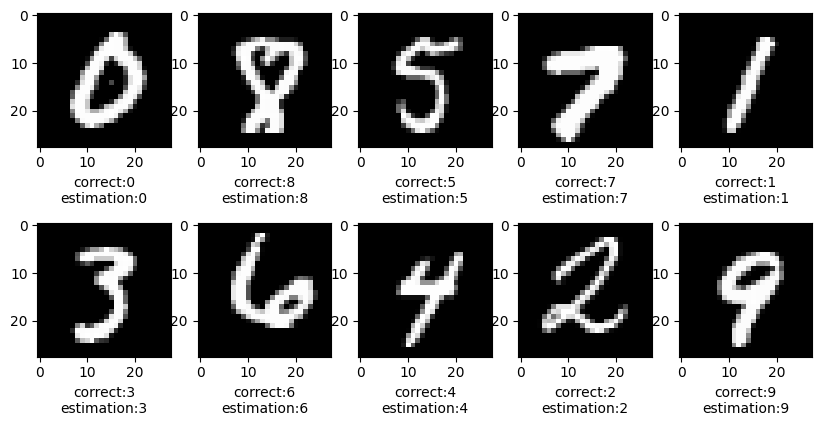

======================= Show accuracy =======================
Loss: 0.07147252559661865, Accuracy: 97.91% (9791/10000)


In [25]:
#6/15 全結合層を用いたMNISTの画像認識

%matplotlib inline
import matplotlib.pyplot as plt

#----------------------------------------------------------
# ハイパーパラメータなどの設定値
num_epochs = 10         # 学習を繰り返す回数
num_batch = 100         # 一度に処理する画像の枚数
learning_rate = 0.001   # 学習率
image_size = 28*28      # 画像の画素数(幅x高さ)

# GPU(CUDA)が使えるかどうか？
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#----------------------------------------------------------
# 学習用／評価用のデータセットの作成

# 変換方法の指定
transform = transforms.Compose([
    transforms.ToTensor()
    ])

# MNISTデータの取得
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
# 学習用
train_dataset = datasets.MNIST(
    './data',               # データの保存先
    train = True,           # 学習用データを取得する
    download = True,        # データが無い時にダウンロードする
    transform = transform   # テンソルへの変換など
    )
# 評価用
test_dataset = datasets.MNIST(
    './data',
    train = False,
    transform = transform
    )

# データローダー
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = num_batch,
    shuffle = True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = num_batch,
    shuffle = True)

#----------------------------------------------------------
# ニューラルネットワークモデルの定義
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()

        # 各クラスのインスタンス（入出力サイズなどの設定）
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 順伝播の設定（インスタンスしたクラスの特殊メソッド(__call__)を実行）
        x = self.fc1(x)
        x = self.relu(x) #活性化関数
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

#----------------------------------------------------------
# ニューラルネットワークの生成
model = Net(image_size, 10).to(device)

#----------------------------------------------------------
# 損失関数の設定
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSE()
#----------------------------------------------------------
# 最適化手法の設定
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#----------------------------------------------------------
# 学習
model.train()  # モデルを訓練モードにする

for epoch in range(num_epochs): # 学習を繰り返し行う
    loss_sum = 0

    for inputs, labels in train_dataloader:

        # GPUが使えるならGPUにデータを送る
        inputs = inputs.to(device)
        labels = labels.to(device)

        # optimizerを初期化
        optimizer.zero_grad()

        # ニューラルネットワークの処理を行う
        inputs = inputs.view(-1, image_size) # 画像データ部分を一次元へ並び変える
        outputs = model(inputs)

        # 損失(出力とラベルとの誤差)の計算
        loss = criterion(outputs, labels)
        loss_sum += loss

        # 勾配の計算
        loss.backward()

        # 重みの更新
        optimizer.step()

    # 学習状況の表示
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum.item() / len(train_dataloader)}")

    # モデルの重みの保存
    torch.save(model.state_dict(), 'model_weights.pth')

#----------------------------------------------------------
# 評価
model.eval()  # モデルを評価モードにする

loss_sum = 0
correct = 0
show_labels = [0,1,2,3,4,5,6,7,8,9]
show_img_list = []

with torch.no_grad():
    for inputs, labels in test_dataloader:

        # GPUが使えるならGPUにデータを送る
        inputs = inputs.to(device)
        inputs_copy = inputs
        labels = labels.to(device)

        # ニューラルネットワークの処理を行う
        inputs = inputs.view(-1, image_size) # 画像データ部分を一次元へ並び変える
        outputs = model(inputs)

        # 正解の値を取得
        pred = outputs.argmax(1)

        for v in show_labels:
            if v == labels[0]:
                show_labels.remove(v)
                img = inputs_copy[0].squeeze().to('cpu').detach().numpy().copy()
                show_img_list.append((img,v,pred[0].item()))
        # 損失(出力とラベルとの誤差)の計算
        loss_sum += criterion(outputs, labels)

        # 正解数をカウント
        correct += pred.eq(labels.view_as(pred)).sum().item()

print("======================= Visualize image =======================")
fig = plt.figure(figsize=(10,5))
for idx, v in enumerate(show_img_list):
    ax = fig.add_subplot(2, 5, idx+1)
    ax.imshow(v[0],cmap="gray")
    ax.set_xlabel("correct:" + str(v[1]) + "\n" + "estimation:" + str(v[2]))
plt.show()

print("======================= Show accuracy =======================")
print(f"Loss: {loss_sum.item() / len(test_dataloader)}, Accuracy: {100*correct/len(test_dataset)}% ({correct}/{len(test_dataset)})")